In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import statistics as s
import os
torch.manual_seed(1)
os.environ['KMP_DUPLICATE_LIB_OK']='True'


In [12]:
import torch
from torchvision import datasets, transforms

def prepare_data_loaders(training_batch_size, evaluation_batch_size):

    image_transforms = transforms.Compose([
        transforms.Resize((32, 32)),  
        transforms.ToTensor()         
    ])
    
    
    mnist_training_loader = torch.utils.data.DataLoader(
        datasets.MNIST(root='data_mnist', train=True, download=True,
                       transform=image_transforms),
        batch_size=training_batch_size, shuffle=True)
    
    
    mnist_evaluation_loader = torch.utils.data.DataLoader(
        datasets.MNIST(root='data_mnist', train=False,
                       transform=image_transforms),
        batch_size=evaluation_batch_size, shuffle=False)  

    return mnist_training_loader, mnist_evaluation_loader


In [13]:
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        
        self.conv_layer1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv_layer2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        
        self.dense_layer1 = nn.Linear(in_features=16 * 5 * 5, out_features=120)
        self.dense_layer2 = nn.Linear(in_features=120, out_features=84)
        self.output_layer = nn.Linear(in_features=84, out_features=10)

    def forward(self, input_tensor):
        input_tensor = F.max_pool2d(F.relu(self.conv_layer1(input_tensor)), kernel_size=2)
        input_tensor = F.max_pool2d(F.relu(self.conv_layer2(input_tensor)), kernel_size=2)
        input_tensor = input_tensor.view(-1, 16 * 5 * 5)
        input_tensor = F.relu(self.dense_layer1(input_tensor))
        input_tensor = F.relu(self.dense_layer2(input_tensor))
        input_tensor = self.output_layer(input_tensor)
        return input_tensor


In [14]:
import torch
from torch.autograd import Variable
from torch.nn import CrossEntropyLoss

import torch.optim as optim

def configure_optimizer(network):
    learning_rate = 0.01  
    momentum_coefficient = 0.9
    use_nesterov = True


    sgd_optimizer = optim.SGD(
        network.parameters(), 
        lr=learning_rate, 
        momentum=momentum_coefficient, 
        nesterov=use_nesterov
    )

    return sgd_optimizer

def train_network(network, sgd_optimizer, mnist_training_loader):
    network.train()  
    criterion = CrossEntropyLoss()  
    
    for batch_index, (inputs, labels) in enumerate(mnist_training_loader):
        inputs, labels = Variable(inputs), Variable(labels)
        sgd_optimizer.zero_grad()  

        predictions = network(inputs)
        training_loss = criterion(predictions, labels)  
        training_loss.backward() 
        sgd_optimizer.step()  

def evaluate_performance(network, dataset_loader, criterion):
    total_correct = 0
    total_samples = 0
    accumulated_loss = 0
    batch_count = 0
    
    with torch.no_grad():
        for batch_data in dataset_loader:
            inputs, targets = batch_data
            predictions = network(inputs)
            loss = criterion(predictions, targets)
            accumulated_loss += loss.item()  
            batch_count += 1
            total_correct += (predictions.argmax(dim=1) == targets).type(torch.float).sum().item()
            total_samples += targets.size(0)
    
    average_loss = accumulated_loss / batch_count
    accuracy = total_correct / total_samples
    
    return average_loss, round(accuracy, 3)

In [18]:
epochs = 30
def execute_training_and_evaluation(network_model, sgd_optimizer, training_loader, testing_loader, loss_criterion):
    losses_training = []
    losses_validation = []
    accuracy_training = []
    accuracy_validation = []

    for current_epoch in range(1, epochs + 1):
        train_network(network_model, sgd_optimizer, training_loader)

        loss_training, acc_training = evaluate_performance(network_model, training_loader, loss_criterion)

        loss_validation, acc_validation = evaluate_performance(network_model, testing_loader, loss_criterion)

        print(f"Epoch {current_epoch} - Training Loss: {loss_training:.4f}, Validation Loss: {loss_validation:.4f}, Training Acc: {acc_training:.2f}, Validation Acc: {acc_validation:.2f}")

        # Append results for plotting or analysis
        losses_training.append(loss_training)
        losses_validation.append(loss_validation)
        accuracy_training.append(acc_training)
        accuracy_validation.append(acc_validation)

    return losses_training, losses_validation, accuracy_training, accuracy_validation


In [19]:
torch.manual_seed(1)

criterion = CrossEntropyLoss()

mnist_training_loader_large, mnist_testing_loader_large = prepare_data_loaders(500, 500)
model_large_batch = CustomCNN()
optimizer_large_batch = configure_optimizer(model_large_batch)

losses_train_large, losses_test_large, acc_train_large, acc_test_large = execute_training_and_evaluation(
    model_large_batch, 
    optimizer_large_batch, 
    mnist_training_loader_large, 
    mnist_testing_loader_large, 
    criterion
)
params_vector_large = torch.nn.utils.parameters_to_vector(model_large_batch.parameters())

torch.manual_seed(1)

mnist_training_loader_small, mnist_testing_loader_small = prepare_data_loaders(100, 100)
model_small_batch = CustomCNN()
optimizer_small_batch = configure_optimizer(model_small_batch)

losses_train_small, losses_test_small, acc_train_small, acc_test_small = execute_training_and_evaluation(
    model_small_batch, 
    optimizer_small_batch, 
    mnist_training_loader_small, 
    mnist_testing_loader_small, 
    criterion
)
params_vector_small = torch.nn.utils.parameters_to_vector(model_small_batch.parameters())

Epoch 1 - Training Loss: 1.4437, Validation Loss: 1.4610, Training Acc: 0.51, Validation Acc: 0.50
Epoch 2 - Training Loss: 0.2447, Validation Loss: 0.2265, Training Acc: 0.92, Validation Acc: 0.93
Epoch 3 - Training Loss: 0.1528, Validation Loss: 0.1398, Training Acc: 0.95, Validation Acc: 0.96
Epoch 4 - Training Loss: 0.1193, Validation Loss: 0.1085, Training Acc: 0.96, Validation Acc: 0.97
Epoch 5 - Training Loss: 0.0936, Validation Loss: 0.0876, Training Acc: 0.97, Validation Acc: 0.97
Epoch 6 - Training Loss: 0.0825, Validation Loss: 0.0810, Training Acc: 0.97, Validation Acc: 0.97
Epoch 7 - Training Loss: 0.0673, Validation Loss: 0.0677, Training Acc: 0.98, Validation Acc: 0.98
Epoch 8 - Training Loss: 0.0615, Validation Loss: 0.0625, Training Acc: 0.98, Validation Acc: 0.98
Epoch 9 - Training Loss: 0.0575, Validation Loss: 0.0627, Training Acc: 0.98, Validation Acc: 0.98
Epoch 10 - Training Loss: 0.0505, Validation Loss: 0.0550, Training Acc: 0.98, Validation Acc: 0.98
Epoch 11 

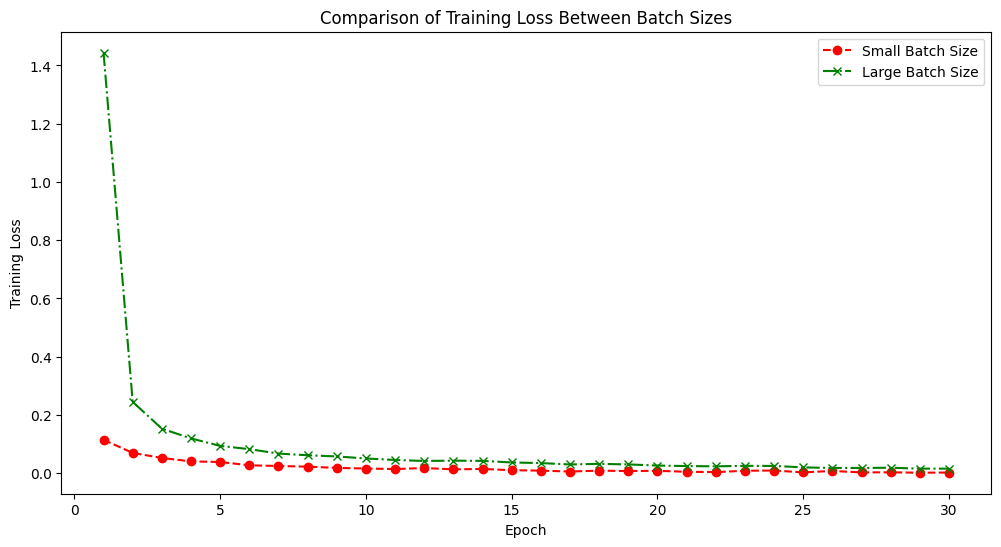

In [21]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 6))

plt.plot(np.arange(1, epochs + 1), losses_train_small, color="red", linestyle="--", marker='o', label='Small Batch Size')

plt.plot(np.arange(1, epochs + 1), losses_train_large, color="green", linestyle="-.", marker='x', label='Large Batch Size')

plt.title('Comparison of Training Loss Between Batch Sizes')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend(loc='upper right')

plt.show()


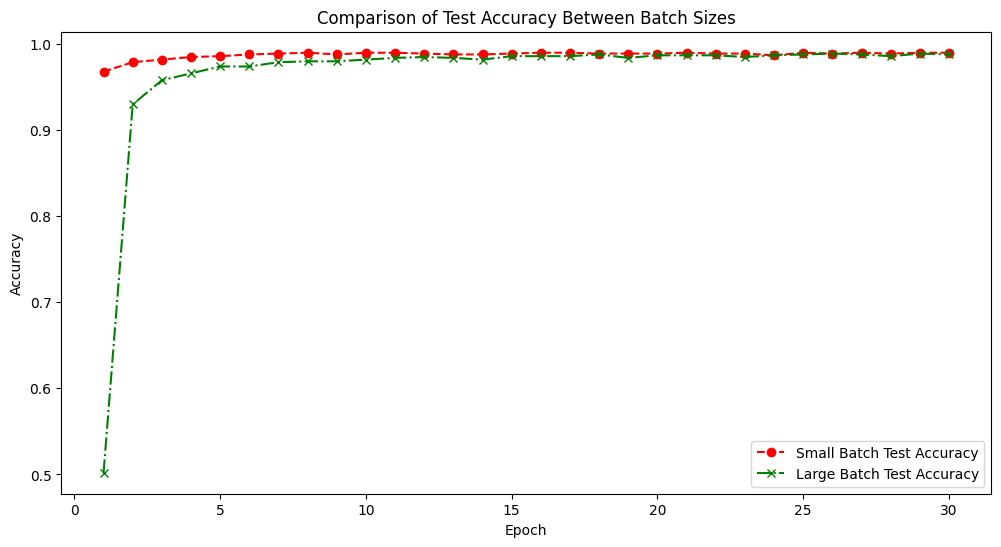

In [22]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 6))

plt.plot(np.arange(1, epochs + 1), acc_test_small, color="red", linestyle="--", marker='o', label='Small Batch Test Accuracy')

plt.plot(np.arange(1, epochs + 1), acc_test_large, color="green", linestyle="-.", marker='x', label='Large Batch Test Accuracy')

plt.title('Comparison of Test Accuracy Between Batch Sizes')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend(loc='lower right')

plt.show()


In [23]:
import numpy as np
import torch

alpha = np.linspace(-2.0, 2.0, num=50)
thetaArr = []

for alpha_value in alpha:
    interpolated_theta = (1 - alpha_value) * params_vector_small + alpha_value * params_vector_large
    thetaArr.append(interpolated_theta)


In [25]:
alpha_train_loss_arr = []
alpha_test_loss_arr = []
alpha_train_acc_arr = []
alpha_test_acc_arr = []

for i, theta in enumerate(thetaArr):
    torch.manual_seed(1)  

    interpolated_model = CustomCNN()
    torch.nn.utils.vector_to_parameters(theta, interpolated_model.parameters())
    
    train_loss, train_acc = evaluate_performance(interpolated_model, mnist_training_loader_large, criterion)
    test_loss, test_acc = evaluate_performance(interpolated_model, mnist_testing_loader_large, criterion)
    

    alpha_train_loss_arr.append(train_loss)
    alpha_train_acc_arr.append(train_acc)
    alpha_test_loss_arr.append(test_loss)
    alpha_test_acc_arr.append(test_acc)


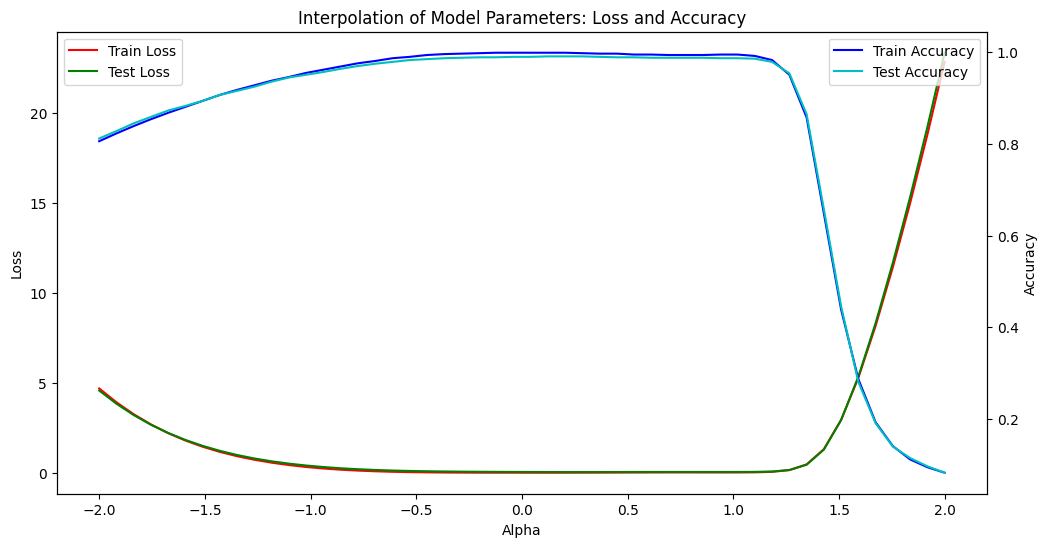

In [26]:
plt.figure(figsize=(12, 6))

# Plot training and testing loss
plt.plot(alpha, alpha_train_loss_arr, color="r", label='Train Loss')
plt.plot(alpha, alpha_test_loss_arr, color="g", label='Test Loss')
plt.xlabel('Alpha')
plt.ylabel('Loss')
plt.legend(loc='upper left')

# Create a twin y-axis to plot training and testing accuracy
ax2 = plt.twinx()
ax2.plot(alpha, alpha_train_acc_arr, color="b", label='Train Accuracy')
ax2.plot(alpha, alpha_test_acc_arr, color="c", label='Test Accuracy')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='upper right')

plt.title('Interpolation of Model Parameters: Loss and Accuracy')
plt.show()
